# Import Module & Define Function

In [2]:
# import the necessary packages
import imutils
import cv2
from matplotlib import pyplot as plt
import numpy
import os
import pandas
import csv
import pickle

## File Operations

In [3]:
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename))
        if img is not None:
            images.append(img)
    return images

In [4]:
def count_files(path):
    count = 0
    for root_dir, cur_dir, files in os.walk(path):
        count += len(files)
    return count

## Get dictionary key

In [34]:
# function to return key for any value
def get_key_dict(val):
    val_bw = cv2.cvtColor(val, cv2.COLOR_BGR2GRAY)
    val_bin = numpy.interp(val_bw, (val_bw.min(), val_bw.max()), (0, +1))
    for key, dict_list in number_dictionary.items():
        for dict_val in dict_list:
            if numpy.array_equal(val_bin,dict_val):
                return True, key
    return False, 0

In [35]:
def get_current_time(current_frame, last_time, frame):
    d100 = frame[24:31,208:215]
    d10 = frame[24:31,216:223]
    d1 = frame[24:31,224:231]
    
    num1_valid, time_num1 = get_key_dict(d1)
    if not num1_valid:
        return last_time
    num10_valid, time_num10 = get_key_dict(d10)
    if not num10_valid:
        return last_time
    num100_valid, time_num100 = get_key_dict(d100)
    if not num100_valid:
        return last_time

    cur_time = int(f"{time_num100}{time_num10}{time_num1}")
    return cur_time

## Check new info

In [36]:
def new_stage_check(current_frame, last_stage, frame):
    frame_stage_1 = frame[24:31,152:159]
    frame_stage_2 = frame[24:31,168:175]
    num1_valid, stage_num1 = get_key_dict(frame_stage_1)
    num2_valid, stage_num2 = get_key_dict(frame_stage_2)
    if not num1_valid&num2_valid:
        return False, last_stage
    if f"{stage_num1}-{stage_num2}" == last_stage:
        return False, last_stage
    else: 
        return True, f"{stage_num1}-{stage_num2}"

In [37]:
def new_score_check(current_frame, last_score, frame):
    d1 = frame[24:31,48:55]
    d10 = frame[24:31,40:47]
    d100 = frame[24:31,32:39]
    
    num1_valid, score_num1 = get_key_dict(d1)
    if not num1_valid:
        return False, last_score
    num10_valid, score_num10 = get_key_dict(d10)
    if not num10_valid:
        return False, last_score
    num100_valid, score_num100 = get_key_dict(d100)
    if not num100_valid:
        return False, last_score

    ## convert new_score and compare with previous score
    new_score = int(f"{score_num100}{score_num10}{score_num1}")
    if new_score == last_score:
        return False, last_score
    else: 
        return True, new_score
    

In [112]:
def status_down_check(frame_num, counting_time, function_counter, stage, frame):
    cur_time = get_current_time(frame_num, counting_time, frame)
    if (cur_time==stage_limit.get(stage)):
        function_counter=0
        return True, cur_time, function_counter, True
    if (cur_time==(stage_limit.get(stage)-1)):
        return False, cur_time, function_counter, False
    if (function_counter>TIME_THRESHOLD and cur_time==counting_time):
        function_counter=0
        return True, cur_time, function_counter, False
    elif (cur_time != counting_time):
        function_counter=0
        return False, cur_time, function_counter, False
    else:
        function_counter = function_counter+1
        return False, cur_time, function_counter, False

# Loading Dictionary

In [39]:
file_score_display = open("./data_dump/number_dictionary.npy", "rb")
number_dictionary = pickle.load(file_score_display)
print(number_dictionary[1][0])
file_score_display.close()

[[0. 0. 0. 1. 1. 0. 0.]
 [0. 0. 1. 1. 1. 0. 0.]
 [0. 0. 0. 1. 1. 0. 0.]
 [0. 0. 0. 1. 1. 0. 0.]
 [0. 0. 0. 1. 1. 0. 0.]
 [0. 0. 0. 1. 1. 0. 0.]
 [0. 1. 1. 1. 1. 1. 1.]]


In [101]:
stage_limit = {
    '1-1': 400, '1-2': 400, '1-3': 300, '1-4': 300,
    '2-1': 400, '2-2': 400, '2-3': 300, '2-4': 300,
    '3-1': 400, '3-2': 300, '3-3': 300, '3-4': 300,
    '4-1': 400, '4-2': 400, '4-3': 300, '4-4': 400,
    '5-1': 300, '5-2': 400, '5-3': 300, '5-4': 300,
    '6-1': 400, '6-2': 400, '6-3': 300, '6-4': 300,
    '7-1': 400, '7-2': 400, '7-3': 300, '7-4': 400,
    '8-1': 400, '8-2': 400, '8-3': 400, '8-4': 300  ### to check
}

In [41]:
event_dictionary = {
    0: "new_stage",
    1: "flag_reached",
    2: "status_up",
    3: "status_down",
    4: "life_lost"
}

# Comparison & Prediction

In [40]:
participant = 0  ### change for different participant

In [138]:
current_frame = 1
current_score = 0
current_stage = "1-1"
TIME_THRESHOLD=35
time_frozen = False
counter = 1
lock_counter = 0
counting_time=400
event_frame = []

print(f"start participant {participant}")
for frame_number in range(1,count_files(f'game_frame/game_frame_participant_{participant}/')):
    current_time = counting_time            
    # read frame
    frame = cv2.imread(f'game_frame/game_frame_participant_{participant}/game_{frame_number}.png')
    # prediction

    flag_score, new_score = new_score_check(frame_number, current_score, frame)
    flag_stage, next_stage = new_stage_check(frame_number, current_stage, frame)
    flag_time, counting_time, counter, time_frozen_now = status_down_check(frame_number, counting_time, counter, current_stage, frame)

    if flag_stage:
        current_stage = next_stage
        current_score = 0
        event_frame.append((frame_number-1, next_stage, 0, 1))
        event_frame.append((frame_number, next_stage, 0, 0))
        #print("###### new_stage")
        # print((frame_number, next_stage, 0,0))

    elif flag_score:
        if new_score == 0 and time_frozen_now:  ############# need to add time condition
            event_frame.append((frame_number-1, current_stage, new_score,4))
            #print("####### life_lost")
            # print((frame_number-1, current_stage, new_score,4))
        elif ((new_score-current_score) == 10):
            lock_counter = 0
            event_frame.append((frame_number-6, current_stage, new_score,2))
            #print("###### status up")
            #print((frame_number-6, current_stage, new_score,2))
        current_score = new_score

    elif flag_time:
        if (counting_time == stage_limit.get(current_stage)) and not time_frozen_before:
            event_frame.append((frame_number-1, current_stage, new_score,4))
            # print("####### life_lost")
            # print((frame_number-1, current_stage, new_score,4))

        elif (counting_time == stage_limit.get(current_stage)) and (not(counting_time == stage_limit.get(current_stage))) and not time_frozen_before:
                event_frame.append((frame_number-1, current_stage, new_score,4))
                #print("####### life_lost")
                # print((frame_number-1, current_stage, new_score,4))

        elif not (counting_time == stage_limit.get(current_stage)) and (lock_counter>100):
            lock_counter = 35
            event_frame.append((frame_number-35, current_stage, current_score,3))
            #print("###### status down")
            # print((frame_number-35, current_stage, current_score,3))
            #time_frozen_before = False

    lock_counter += 1
    time_frozen_before = time_frozen_now

print(f"recording participant {participant}")

for frame in event_frame:
    event_list.append([frame[0],event_dictionary[frame[3]]])
    print(f'{frame[0]},{event_dictionary[frame[3]]}')

with open(f'./game_frame/predictions/game_frame_participant_{participant}.csv', 'w') as f:
    # using csv.writer method from CSV package
    write = csv.writer(f)
    write.writerows(event_list)

print(f"end participant {participant}")
print(event_frame)

start participant 0
recording participant 0
0,life_lost
428,status_up
1915,flag_reached
1916,new_stage
2003,life_lost
2369,status_up
2545,status_down
3030,status_up
4400,flag_reached
4401,new_stage
4401,life_lost
4694,life_lost
5502,status_up
6055,status_down
6453,flag_reached
6454,new_stage
6454,life_lost
7735,life_lost
9978,flag_reached
9979,new_stage
9979,life_lost
11502,flag_reached
11503,new_stage
11503,life_lost
12626,life_lost
14184,life_lost
15475,life_lost
15695,life_lost
17154,life_lost
19713,flag_reached
19714,new_stage
19997,life_lost
20695,life_lost
20885,life_lost
22313,flag_reached
22314,new_stage
22455,life_lost
22695,life_lost
23641,life_lost
24141,life_lost
24613,life_lost
25699,life_lost
28088,flag_reached
28089,new_stage
28089,life_lost
29214,life_lost
30645,flag_reached
30646,new_stage
31190,life_lost
31714,life_lost
32196,life_lost
32728,life_lost
33292,life_lost
34621,flag_reached
34622,new_stage
35125,life_lost
36686,flag_reached
36687,new_stage
37364,status_up


In [ ]:
current_frame = 1
current_score = 0
current_stage = "1-1"
TIME_THRESHOLD=35
time_frozen = True
counter = 1
lock_counter = 0
counting_time=400
event_frame = []
participant = 0

for frame_number in range(18000,count_files(f'game_frame/game_frame_participant_{participant}/')):
    print(frame_number)
    current_time = counting_time            
    # read frame
    frame = cv2.imread(f'game_frame/game_frame_participant_{participant}/game_{frame_number}.png')
    # prediction
    
    
    flag_score, new_score = new_score_check(frame_number, current_score, frame)
    flag_stage, next_stage = new_stage_check(frame_number, current_stage, frame)
    flag_time, counting_time, counter, time_frozen_now = status_down_check(frame_number, counting_time, counter, current_stage, frame)
    
    
            
    if flag_stage:
        current_stage = next_stage
        current_score = 0
        event_frame.append((frame_number-1, next_stage, 0, 1))
        event_frame.append((frame_number, next_stage, 0, 0))
        #print("###### new_stage")
        print((frame_number, next_stage, 0,0))

    elif flag_score:
        if new_score == 0 and time_frozen_now:  ############# need to add time condition
            event_frame.append((frame_number-1, current_stage, new_score,4))
            #print("####### life_lost")
            print((frame_number-1, current_stage, new_score,4))
        elif ((new_score-current_score) == 10):
            lock_counter = 0
            event_frame.append((frame_number-6, current_stage, new_score,2))
            #print("###### status up")
            #print((frame_number-6, current_stage, new_score,2))
        current_score = new_score
    
    elif flag_time:
        if (counting_time == stage_limit.get(current_stage)) and not time_frozen_before:
            event_frame.append((frame_number-1, current_stage, new_score,4))
            #print("####### life_lost")
            print((frame_number-1, current_stage, new_score,4))
            
        elif (counting_time == stage_limit.get(current_stage)) and (not(counting_time == stage_limit.get(current_stage))) and not time_frozen_before:
                event_frame.append((frame_number-1, current_stage, new_score,4))
                #print("####### life_lost")
                print((frame_number-1, current_stage, new_score,4))
                
        elif not (counting_time == stage_limit.get(current_stage)) and (lock_counter>100):
            lock_counter = 35
            event_frame.append((frame_number-35, current_stage, current_score,3))
            #print("###### status down")
            print((frame_number-35, current_stage, current_score,3))
            #time_frozen_before = False
            
    lock_counter += 1
    time_frozen_before = time_frozen_now

for frame in event_frame:
    event_list.append([frame[0],event_dictionary[frame[3]]])
    print(f'{frame[0]},{event_dictionary[frame[3]]}')

with open(f'./game_frame/predictions/game_frame_participant_{participant}.csv', 'w') as f:
    # using csv.writer method from CSV package
    write = csv.writer(f)
    write.writerows(event_list)
    
print(event_frame)

testing

In [120]:
current_frame = 1
current_score = 0
current_stage = "1-1"
current_stage = "3-1" ##################
TIME_THRESHOLD=35
time_frozen = True
counter = 1
lock_counter = 0
counting_time=400
event_frame = []
participant = 0

for frame_number in range(92850,count_files(f'game_frame/game_frame_participant_{participant}/')):
    print(frame_number)
    current_time = counting_time            
    # read frame
    frame = cv2.imread(f'game_frame/game_frame_participant_{participant}/game_{frame_number}.png')
    # prediction
    
    
    flag_score, new_score = new_score_check(frame_number, current_score, frame)
    flag_stage, next_stage = new_stage_check(frame_number, current_stage, frame)
    flag_time, counting_time, counter, time_frozen_now = status_down_check(frame_number, counting_time, counter, current_stage, frame)
    print(next_stage)
    
            
    if flag_stage:
        current_stage = next_stage
        current_score = 0
        event_frame.append((frame_number-1, next_stage, 0, 1))
        event_frame.append((frame_number, next_stage, 0, 0))
        #print("###### new_stage")
        print((frame_number, next_stage, 0,0))

    elif flag_score:
        if new_score == 0 and time_frozen_now:  ############# need to add time condition
            event_frame.append((frame_number-1, current_stage, new_score,4))
            #print("####### life_lost")
            print((frame_number-1, current_stage, new_score,4))
        elif ((new_score-current_score) == 10):
            lock_counter = 0
            event_frame.append((frame_number-6, current_stage, new_score,2))
            #print("###### status up")
            #print((frame_number-6, current_stage, new_score,2))
        current_score = new_score
    
    elif flag_time:
        if (counting_time == stage_limit.get(current_stage)) and not time_frozen_before:
            event_frame.append((frame_number-1, current_stage, new_score,4))
            #print("####### life_lost")
            print((frame_number-1, current_stage, new_score,4))
            
        elif (counting_time == stage_limit.get(current_stage)) and (not(counting_time == stage_limit.get(current_stage))) and not time_frozen_before:
                event_frame.append((frame_number-1, current_stage, new_score,4))
                #print("####### life_lost")
                print((frame_number-1, current_stage, new_score,4))
                
        elif not (counting_time == stage_limit.get(current_stage)) and (lock_counter>100):
            lock_counter = 35
            event_frame.append((frame_number-35, current_stage, current_score,3))
            #print("###### status down")
            print((frame_number-35, current_stage, current_score,3))
            #time_frozen_before = False
            
    lock_counter += 1
    time_frozen_before = time_frozen_now

#for frame in event_frame:
#    event_list.append([frame[0],event_dictionary[frame[3]]])
#    print(f'{frame[0]},{event_dictionary[frame[3]]}')

#with open(f'./game_frame/predictions/game_frame_participant_{participant}.csv', 'w') as f:
#    # using csv.writer method from CSV package
#    write = csv.writer(f)
#    write.writerows(event_list)
    
print(event_frame)

92850
6-4
(92850, '6-4', 0, 0)
92851
6-4
92852
6-4
92853
6-4
92854
6-4
92855
6-4
92856
6-4
92857
6-4
92858
6-4
92859
6-4
92860
6-4
92861
6-4
92862
6-4
92863
6-4
92864
7-1
(92864, '7-1', 0, 0)
92865
7-1
(92864, '7-1', 0, 4)
92866
7-1
92867
7-1
92868
7-1
92869
7-1
92870
7-1
92871
7-1
92872
7-1
92873
7-1
92874
7-1
92875
7-1
92876
7-1
92877
7-1
92878
7-1
92879
7-1
92880
7-1
92881
7-1
92882
7-1
92883
7-1
92884
7-1
92885
7-1
92886
7-1
92887
7-1
92888
7-1
92889
7-1
92890
7-1
92891
7-1
92892
7-1
92893
7-1
92894
7-1
92895
7-1
92896
7-1
92897
7-1
92898
7-1
92899
7-1
92900
7-1
92901
7-1
92902
7-1
92903
7-1
92904
7-1
92905
7-1
92906
7-1
92907
7-1
92908
7-1
92909
7-1
92910
7-1
92911
7-1
92912
7-1
92913
7-1
92914
7-1
92915
7-1
92916
7-1
92917
7-1
92918
7-1
92919
7-1
92920
7-1
92921
7-1
92922
7-1
92923
7-1
92924
7-1
92925
7-1
92926
7-1
92927
7-1
92928
7-1
92929
7-1
92930
7-1
92931
7-1
92932
7-1
92933
7-1
92934
7-1
92935
7-1
92936
7-1
92937
7-1
92938
7-1
92939
7-1
92940
7-1
92941
7-1
92942
7-1
92943
7

KeyboardInterrupt: 

In [54]:
for participant in range(8,10):
    
    current_frame = 1
    current_score = 0
    current_stage = "1-1"
    TIME_THRESHOLD=35
    time_frozen = True
    counter = 1
    lock_counter = 0
    counting_time=400
    event_frame = []
    event_list = []
    for frame_number in range(1,count_files(f'game_frame/game_frame_participant_{participant}/')):

        current_time = counting_time
        # read frame
        frame = cv2.imread(f'game_frame/game_frame_participant_{participant}/game_{frame_number}.png')
        # prediction
        flag_score, new_score = new_score_check(frame_number, current_score, frame)
        flag_stage, next_stage = new_stage_check(frame_number, current_stage, frame)
        flag_time, counting_time, counter = status_down_check(frame_number, counting_time, counter, frame)

        if flag_time and (counting_time in [400,300]) and not time_frozen:
            time_frozen = True
        elif (counting_time in [399,299]):
            time_frozen = False

        if flag_stage:
            current_stage = next_stage
            current_score = 0
            event_frame.append((frame_number-1, next_stage, 0, 1))
            event_frame.append((frame_number, next_stage, 0, 0))
            #print("###### new_stage")
            print((frame_number, next_stage, 0,0))

        elif flag_score:
            if new_score == 0 or time_frozen:  ############# need to add time condition
                event_frame.append((frame_number-1, current_stage, new_score,4))
                #print("####### life_lost")
                print((frame_number-1, current_stage, new_score,4))
            elif ((new_score-current_score) == 10):
                lock_counter = 0
                event_frame.append((frame_number-6, current_stage, new_score,2))
                #print("###### status up")
                print((frame_number-6, current_stage, new_score,2))
            current_score = new_score

        elif flag_time:
            if (not(current_time in [400,300])) and (counting_time in [400,300]) and not time_frozen:
                event_frame.append((frame_number-1, current_stage, new_score,4))
                #print("####### life_lost")
                print((frame_number-1, current_stage, new_score,4))
            if not (counting_time in [400,300]) and (lock_counter>100):
                lock_counter = 35
                event_frame.append((frame_number-35, current_stage, current_score,3))
                #print("###### status down")
                print((frame_number-35, current_stage, current_score,3))
                time_frozen = False

        lock_counter += 1
        
    print(event_frame)
    
    for frame in event_frame:
        event_list.append([frame[0],event_dictionary[frame[3]]])
        print(f'{frame[0]},{event_dictionary[frame[3]]}')

    with open(f'./game_frame/predictions/game_frame_participant_{participant}.csv', 'w') as f:
        # using csv.writer method from CSV package
        write = csv.writer(f)
        write.writerows(event_list)
        print("csv wrote")
    

ValueError: too many values to unpack (expected 3)

In [25]:
event_list = []
for frame in event_frame:
    if frame[3] == 4:
        print(f'{frame[0]},{event_dictionary[frame[3]]}')        
    event_list.append([frame[0],event_dictionary[frame[3]]])


2003,life_lost
7735,life_lost
12626,life_lost
14184,life_lost
15475,life_lost
17154,life_lost
25699,life_lost
29214,life_lost
40446,life_lost
40869,life_lost
42738,life_lost
46246,life_lost
46499,life_lost
47199,life_lost
53884,life_lost
54118,life_lost
55142,life_lost
55770,life_lost
56494,life_lost
56950,life_lost
58490,life_lost
59040,life_lost
61423,life_lost
62113,life_lost
62449,life_lost
63551,life_lost
63939,life_lost
70866,life_lost
93239,life_lost
93731,life_lost
96648,life_lost
99572,life_lost
104292,life_lost
104882,life_lost
105666,life_lost
106518,life_lost
107034,life_lost
107770,life_lost
108084,life_lost


[ WARN:0@306.345] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('game_frame/game_frame_participant_0/game_4395.png'): can't open/read file: check file path/integrity


TypeError: Image data of dtype object cannot be converted to float

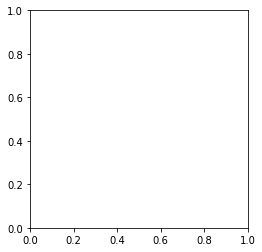

In [7]:
framesx = 4400
for frame_number in range(framesx-5,framesx+5):
    frame1 = cv2.imread(f'game_frame/game_frame_participant_0/game_{frame_number}.png')
    plt.imshow(frame1)
    plt.show()

In [81]:
event_list = []
for frame in event_frame:
    event_list.append([frame[0],event_dictionary[frame[3]]])
    print(f'{frame[0]},{event_dictionary[frame[3]]}')

428,status_up
1915,flag_reached
1916,new_stage
2003,life_lost
2369,status_up
2545,status_down
3030,status_up
4400,flag_reached
4401,new_stage
5502,status_up
6055,status_down
6453,flag_reached
6454,new_stage
7735,life_lost
9978,flag_reached
9979,new_stage
11502,flag_reached
11503,new_stage
12626,life_lost
14184,life_lost
15475,life_lost
17154,life_lost
19713,flag_reached
19714,new_stage
22313,flag_reached
22314,new_stage
25699,life_lost
28088,flag_reached
28089,new_stage
29214,life_lost


In [19]:

with open('./game_frame/predictions/game_frame_participant_0.csv', 'w') as f:
    # using csv.writer method from CSV package
    write = csv.writer(f)
    write.writerows(event_list)

In [ ]:
participant = 0 
frame_number = 1
frame = cv2.imread(f'game_frame/game_frame_participant_{participant}/game_{frame_number}.png')
    # prediction
    flag_score, new_score = new_score_check(frame_number, current_score, frame)
    flag_stage, next_stage = new_stage_check(frame_number, current_stage, frame)
    flag_time, counting_time, counter = status_down_check(frame_number, counting_time, counter, frame)